# Real World Facility Location Problem

*Authors:* [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

This tutorial aims to show a facility location application. To achieve this goal the tuorial will solve a real world facility location problem using a dataset describing an area of census tract 205, San Francisco. The problem can be written as: store sites should supply the demand in this census tract considering the distance between the two sites, a demand point and a supply candidate site. 

This tutorial model this problem using four models already developed in literature: LSCP (Location Set Covering Problem), MCLP (Maximal Coverage Location Problem), P-Median and P-Center. If you don't know any of these models, it's recommended to see the notebooks that explain more deeply about each model: [LSCP](./lscp.ipynb), [MCLP](./mclp.ipynb), [P-Median](./p-median.ipynb), [P-Center](./p-center.ipynb)

Besides that, the tutorial show how to use different solvers that [PULP](https://github.com/coin-or/pulp) support.

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-10-18T17:24:38.588405-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import pandas
import pulp
import shapely
from shapely.geometry import Point
import spopt
import time
import warnings

%watermark -w
%watermark -iv

Watermark: 2.3.1

geopandas          : 0.11.1
numpy              : 1.23.3
matplotlib_scalebar: 0.8.1
pandas             : 1.5.0
shapely            : 1.8.5
pulp               : 2.6.0
matplotlib         : 3.6.1
spopt              : 0.4.1+200.g336f235.dirty
json               : 2.0.9



The problem is composed by 4 datafiles
- network_distance is the calculus of distance between facility candidate sites calculated by ArcGIS Network Analyst Extension
- demand_points represents the demand points with some important features for the facility location problem like population
- facility_points represents the stores that are candidate facility sites
- tract is the polygon of census tract 205.

All datasets are online on this [repository](https://github.com/huanfachen/Open_source_location_cover_models/tree/master/Data/San_Francisco_store)

In [3]:
DIRPATH = "../spopt/tests/data/"

`network_distance` dataframe

In [4]:
network_distance = pandas.read_csv(
    DIRPATH + "SF_network_distance_candidateStore_16_censusTract_205_new.csv"
)
network_distance

,distance,name,DestinationName,demand
0,671.573346,Store_1,60750479.01,6540
1,1333.708063,Store_1,60750479.02,3539
2,1656.188884,Store_1,60750352.02,4436
3,1783.006047,Store_1,60750602.00,231
4,1790.950612,Store_1,60750478.00,7787
...,...,...,...,...
3275,19643.307257,Store_19,60816023.00,3204
3276,20245.369594,Store_19,60816029.00,4135
3277,20290.986235,Store_19,60816026.00,7887
3278,20875.680521,Store_19,60816025.00,5146


`demand_points` dataframe

In [5]:
demand_points = pandas.read_csv(
    DIRPATH + "SF_demand_205_centroid_uniform_weight.csv", index_col=0
)
demand_points

,OBJECTID,ID,NAME,STATE_NAME,AREA,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,long,lat
1,1,6081602900,60816029.00,California,0.48627,4135,1679,1715,112,-122.488653,37.650807
2,2,6081602800,60816028.00,California,0.47478,4831,1484,1506,59,-122.483550,37.659998
3,3,6081601700,60816017.00,California,0.46393,4155,1294,1313,55,-122.456484,37.663272
4,4,6081601900,60816019.00,California,0.81907,9041,3273,3330,118,-122.434247,37.662385
5,5,6081602500,60816025.00,California,0.46603,5146,1459,1467,44,-122.451187,37.640219
...,...,...,...,...,...,...,...,...,...,...,...
201,204,6075011100,60750111.00,California,0.09466,5559,2930,3037,362,-122.418479,37.791082
202,205,6075012200,60750122.00,California,0.07211,7035,3862,4074,272,-122.417237,37.785728
203,206,6075017601,60750176.01,California,0.24306,5756,2437,2556,943,-122.410115,37.779459
204,207,6075017800,60750178.00,California,0.27882,5829,3115,3231,807,-122.405411,37.778934


`facility_points` dataframe

In [6]:
facility_points = pandas.read_csv(DIRPATH + "SF_store_site_16_longlat.csv", index_col=0)
facility_points

,OBJECTID,NAME,long,lat
1,1,Store_1,-122.510018,37.772364
2,2,Store_2,-122.488873,37.753764
3,3,Store_3,-122.464927,37.774727
4,4,Store_4,-122.473945,37.743164
5,5,Store_5,-122.449291,37.731545
6,6,Store_6,-122.491745,37.649309
7,7,Store_7,-122.483182,37.701109
8,8,Store_11,-122.433782,37.655364
9,9,Store_12,-122.438982,37.719236
10,10,Store_13,-122.440218,37.745382


`study_area` dataframe

In [7]:
study_area = geopandas.read_file(DIRPATH + "ServiceAreas_4.shp").dissolve()
study_area

,geometry
0,"POLYGON ((-122.45299 37.63898, -122.45415 37.6..."


Plot `study_area`

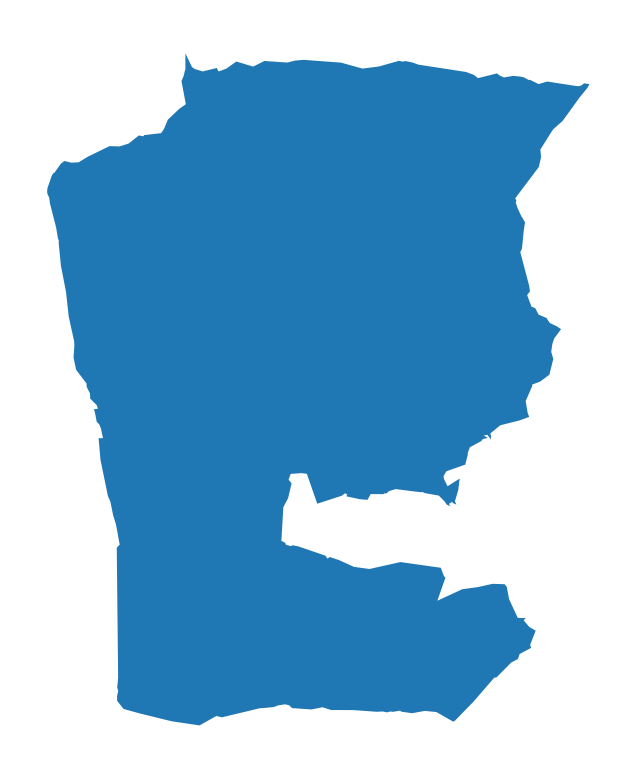

In [8]:
base = study_area.plot()
base.axis("off");

To start modeling the problem assuming the arguments expected by `spopt.locate`, we should pass a numpy 2D array as a cost_matrix. So, first we pivot the network_distance dataframe. 

_Note that the columns and rows are in alphabetically order._

In [9]:
ntw_dist_piv = network_distance.pivot_table(
    values="distance", index="DestinationName", columns="name"
)
ntw_dist_piv

name,Store_1,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7
DestinationName,,,,,,,,,,,,,,,,
60750101.0,11495.190454,20022.666503,10654.593733,8232.543149,7561.399789,4139.772198,4805.805279,2055.530234,225.609240,1757.623456,11522.519829,7529.985950,10847.234951,10604.729605,20970.277793,15242.989416
60750102.0,10436.169910,19392.094770,10024.022001,7601.971416,6930.828057,3093.851654,4175.233547,1257.809690,1041.911304,2333.244000,10509.099285,6470.965406,10216.663219,9974.157873,20339.706061,14612.417684
60750103.0,10746.296811,19404.672860,10036.600090,7614.549505,6943.406146,3381.778555,4187.811636,2046.436590,744.584403,1685.517099,10800.926186,6778.892307,10229.241308,9986.735962,20352.284150,14624.995773
60750104.0,11420.492134,19808.368182,10440.295413,8018.244828,7347.101469,4044.473877,4591.506959,2463.736278,795.715285,1282.217412,11308.221508,7447.187630,10632.936630,10390.431285,20755.979472,15028.691095
60750105.0,11379.443952,19583.920000,10215.847231,7793.796646,7122.653287,4103.725695,4367.058776,3320.283731,1731.462738,249.669959,11083.773326,7379.539448,10408.488448,10165.983103,20531.531290,14804.242913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60816025.0,17324.066610,2722.031291,10884.063331,14178.007937,13891.857275,18418.384867,16726.951785,20834.395022,21441.247824,20875.680521,14662.484617,16569.371114,12483.322114,11926.727459,4968.842581,8648.054204
60816026.0,15981.172325,3647.137006,10299.369046,13593.313651,13307.162990,17833.690581,16142.257500,20249.700736,20856.553539,20290.986235,14050.290332,15963.776829,11871.527828,11342.033174,3625.948296,7919.659919
60816027.0,14835.342712,4581.333336,9637.139433,12931.084039,12644.933377,17171.460969,15480.027887,19587.471124,20194.323926,19628.756623,13341.313338,15301.547216,11209.298215,10679.803561,2290.818683,7242.830306


Here the pivot table is transformed to numpy 2D array such as `spopt.locate` expected. The matrix has a shape of 205x16.

In [10]:
cost_matrix = ntw_dist_piv.to_numpy()
cost_matrix

array([[11495.19045438, 20022.66650296, 10654.59373325, ...,
        10604.72960533, 20970.27779306, 15242.98941606],
       [10436.16991032, 19392.09477041, 10024.0220007 , ...,
         9974.15787278, 20339.70606051, 14612.41768351],
       [10746.29681106, 19404.67285964, 10036.60008993, ...,
         9986.73596201, 20352.28414974, 14624.99577275],
       ...,
       [14835.34271218,  4581.3333364 ,  9637.13943331, ...,
        10679.80356124,  2290.81868301,  7242.83030602],
       [13339.49169134,  6392.85637207,  8577.48841247, ...,
         9620.15254039,  1846.79564734,  5746.97928517],
       [15257.85568393,  6394.92036466, 10253.75240505, ...,
        11296.41653298,   508.93165475,  7665.34327776]])

Now, as the rows and columns of our cost_matrix are sorted, so we have to sort our facility points and demand points geodataframes too. 

In [11]:
n_dem_pnts = demand_points.shape[0]
n_fac_pnts = facility_points.shape[0]

In [12]:
facility_points_gdf = (
    geopandas.GeoDataFrame(
        facility_points,
        geometry=geopandas.points_from_xy(facility_points.long, facility_points.lat),
    )
    .sort_values(by=["NAME"])
    .reset_index()
)

demand_points_gdf = (
    geopandas.GeoDataFrame(
        demand_points,
        geometry=geopandas.points_from_xy(demand_points.long, demand_points.lat),
    )
    .sort_values(by=["NAME"])
    .reset_index()
)

Here the rest of parameters are set.

`ai` is the demand weight and in this case we model as population in year 2000 of this tract.

In [13]:
ai = demand_points_gdf["POP2000"].to_numpy()

service_dist = 5000
p_facility = 4

Below, the method is used to plot the results of the four models that we will prepare to solve the problem.

In [14]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [15]:
def plot_results(
    model, facility_points_gdf, demand_points_gdf, facility_count, title, p
):
    uncov_clients_model = ["MCLP"]

    arr_points = {}
    fac_sites = []

    for i in range(facility_count):
        if model.fac2cli[i]:
            geom = demand_points_gdf.iloc[model.fac2cli[i]]["geometry"]
            arr_points[facility_points_gdf.loc[i, "dv"]] = geom
            fac_sites.append(i)

    if type(model).__name__ in uncov_clients_model:
        model.uncovered_clients()
        xcov = model.n_cli_uncov

    fig, ax = plt.subplots(figsize=(10, 15))
    legend_elements = []

    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)
    _patch = Patch(alpha=0.5, fc="tan", ec="k", label="Dissolved Service Areas")
    legend_elements.append(_patch)

    demand_points_gdf.plot(ax=ax, fc="k", ec="k", marker="s", markersize=7, zorder=2)
    if type(model).__name__ in uncov_clients_model:
        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                marker="s",
                markerfacecolor="k",
                markeredgecolor="k",
                ms=3,
                linewidth=0,
                label=f"Demand sites not covered ($n$={xcov})",
            )
        )

    facility_points_gdf.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    legend_elements.append(
        mlines.Line2D(
            [],
            [],
            marker="*",
            markerfacecolor="brown",
            markeredgecolor="brown",
            ms=7,
            lw=0,
            label=f"Store sites ($n$={facility_count})",
        )
    )

    _zo, _ms = 4, 4
    for i, (fname, geoms) in enumerate(arr_points.items()):

        cset = dv_colors[fname]
        fac = fac_sites[i]
        
        gdf = geopandas.GeoDataFrame(geoms)

        label = f"Demand sites covered by {fname}"
        gdf.plot(ax=ax, zorder=_zo, ec="k", fc=cset, markersize=100 * _ms)
        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                marker="o",
                markerfacecolor=cset,
                markeredgecolor="k",
                ms=_ms + 7,
                lw=0,
                label=label,
            )
        )

        facility_points_gdf.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec="k", lw=2
        )
        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                marker="*",
                markerfacecolor=cset,
                markeredgecolor="k",
                markeredgewidth=2,
                ms=20,
                lw=0,
                label=fname,
            )
        )

        _zo += 1
        _ms -= (1) * (4 / p)

    plt.title(title, fontsize=20)
    kws = dict(loc="upper left", bbox_to_anchor=(1.05, 0.7), fontsize=15)
    plt.legend(handles=legend_elements, **kws)

    x, y, xyc, arrow_length, c = 0.925, 0.15, "axes fraction", 0.1, "center"
    xy, xyt = (x, y), (x, y - arrow_length)
    ap = dict(facecolor="black", width=5, headwidth=10)
    kws = dict(arrowprops=ap, ha=c, va=c, fontsize=20)
    plt.annotate("N", xy=xy, xycoords=xyc, xytext=xyt, **kws)

    plt.gca().add_artist(ScaleBar(1))

In [16]:
for _df in [facility_points_gdf, demand_points_gdf, study_area]:
    _df.set_crs("EPSG:4326", inplace=True)
    _df.to_crs("EPSG:7131", inplace=True)

## LSCP

In [17]:
from spopt.locate import LSCP

In [18]:
lscp = LSCP.from_cost_matrix(cost_matrix, service_dist)

In [19]:
lscp = lscp.solve(pulp.GLPK(msg=False))

Define the decision variable names used for mapping.

In [20]:
facility_points_gdf["dv"] = lscp.fac_vars
facility_points_gdf["dv"] = facility_points_gdf["dv"].map(
    lambda x: x.name.replace("_", "").replace("x", "y")
)
facility_points_gdf

,index,OBJECTID,NAME,long,lat,geometry,dv
0,1,1,Store_1,-122.510018,37.772364,POINT (42712.165 26483.898),y0
1,8,8,Store_11,-122.433782,37.655364,POINT (49431.133 13496.279),y1
2,9,9,Store_12,-122.438982,37.719236,POINT (48971.439 20585.532),y2
3,10,10,Store_13,-122.440218,37.745382,POINT (48862.129 23487.462),y3
4,11,11,Store_14,-122.421636,37.742964,POINT (50499.936 23219.396),y4
5,12,12,Store_15,-122.430982,37.782964,POINT (49675.336 27658.898),y5
6,13,13,Store_16,-122.426873,37.769291,POINT (50037.687 26141.402),y6
7,14,14,Store_17,-122.432345,37.805218,POINT (49554.745 30128.981),y7
8,15,15,Store_18,-122.412818,37.805745,POINT (51274.389 30188.010),y8
9,16,16,Store_19,-122.398909,37.797073,POINT (52499.809 29225.972),y9


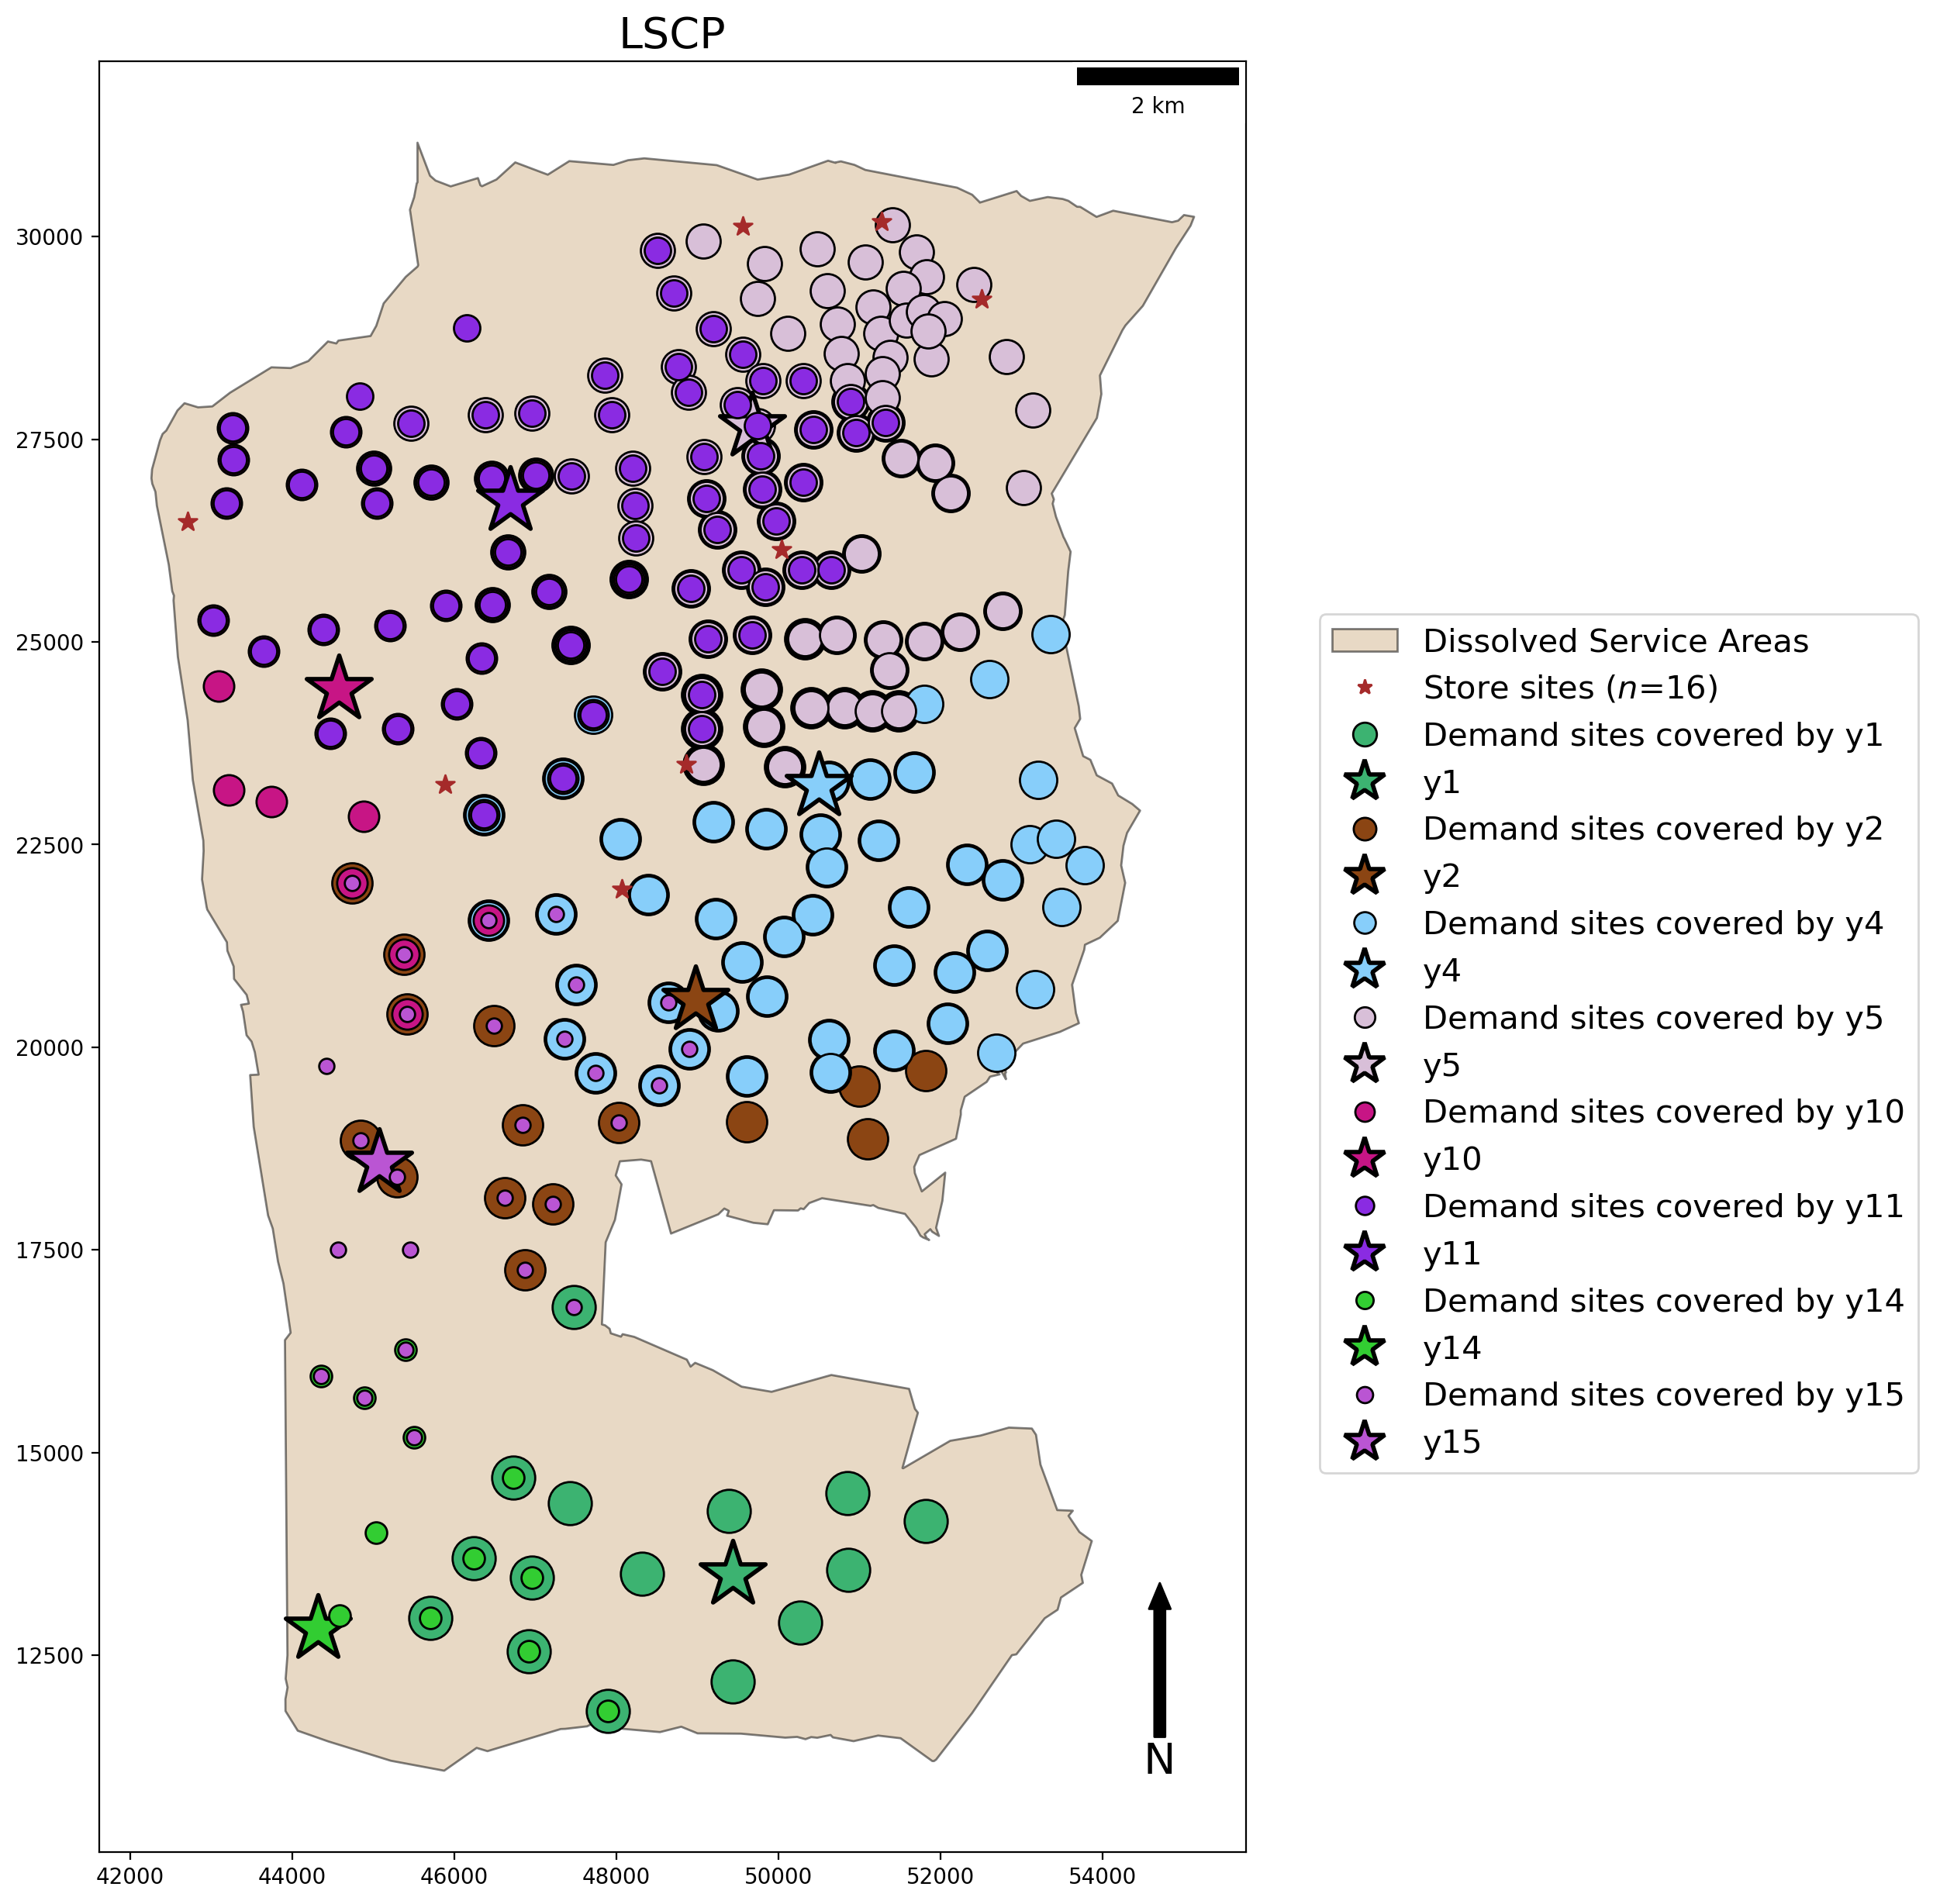

In [21]:
plot_results(
    lscp,
    facility_points_gdf,
    demand_points_gdf,
    n_fac_pnts,
    "LSCP",
    lscp.problem.objective.value(),
)

In [22]:
lscp.problem.objective.value()

8

## MCLP

In [23]:
from spopt.locate import MCLP

In [24]:
mclp = MCLP.from_cost_matrix(
    cost_matrix,
    ai,
    service_radius=service_dist,
    p_facilities=4,
)

In [25]:
mclp = mclp.solve(pulp.GLPK(msg=False))

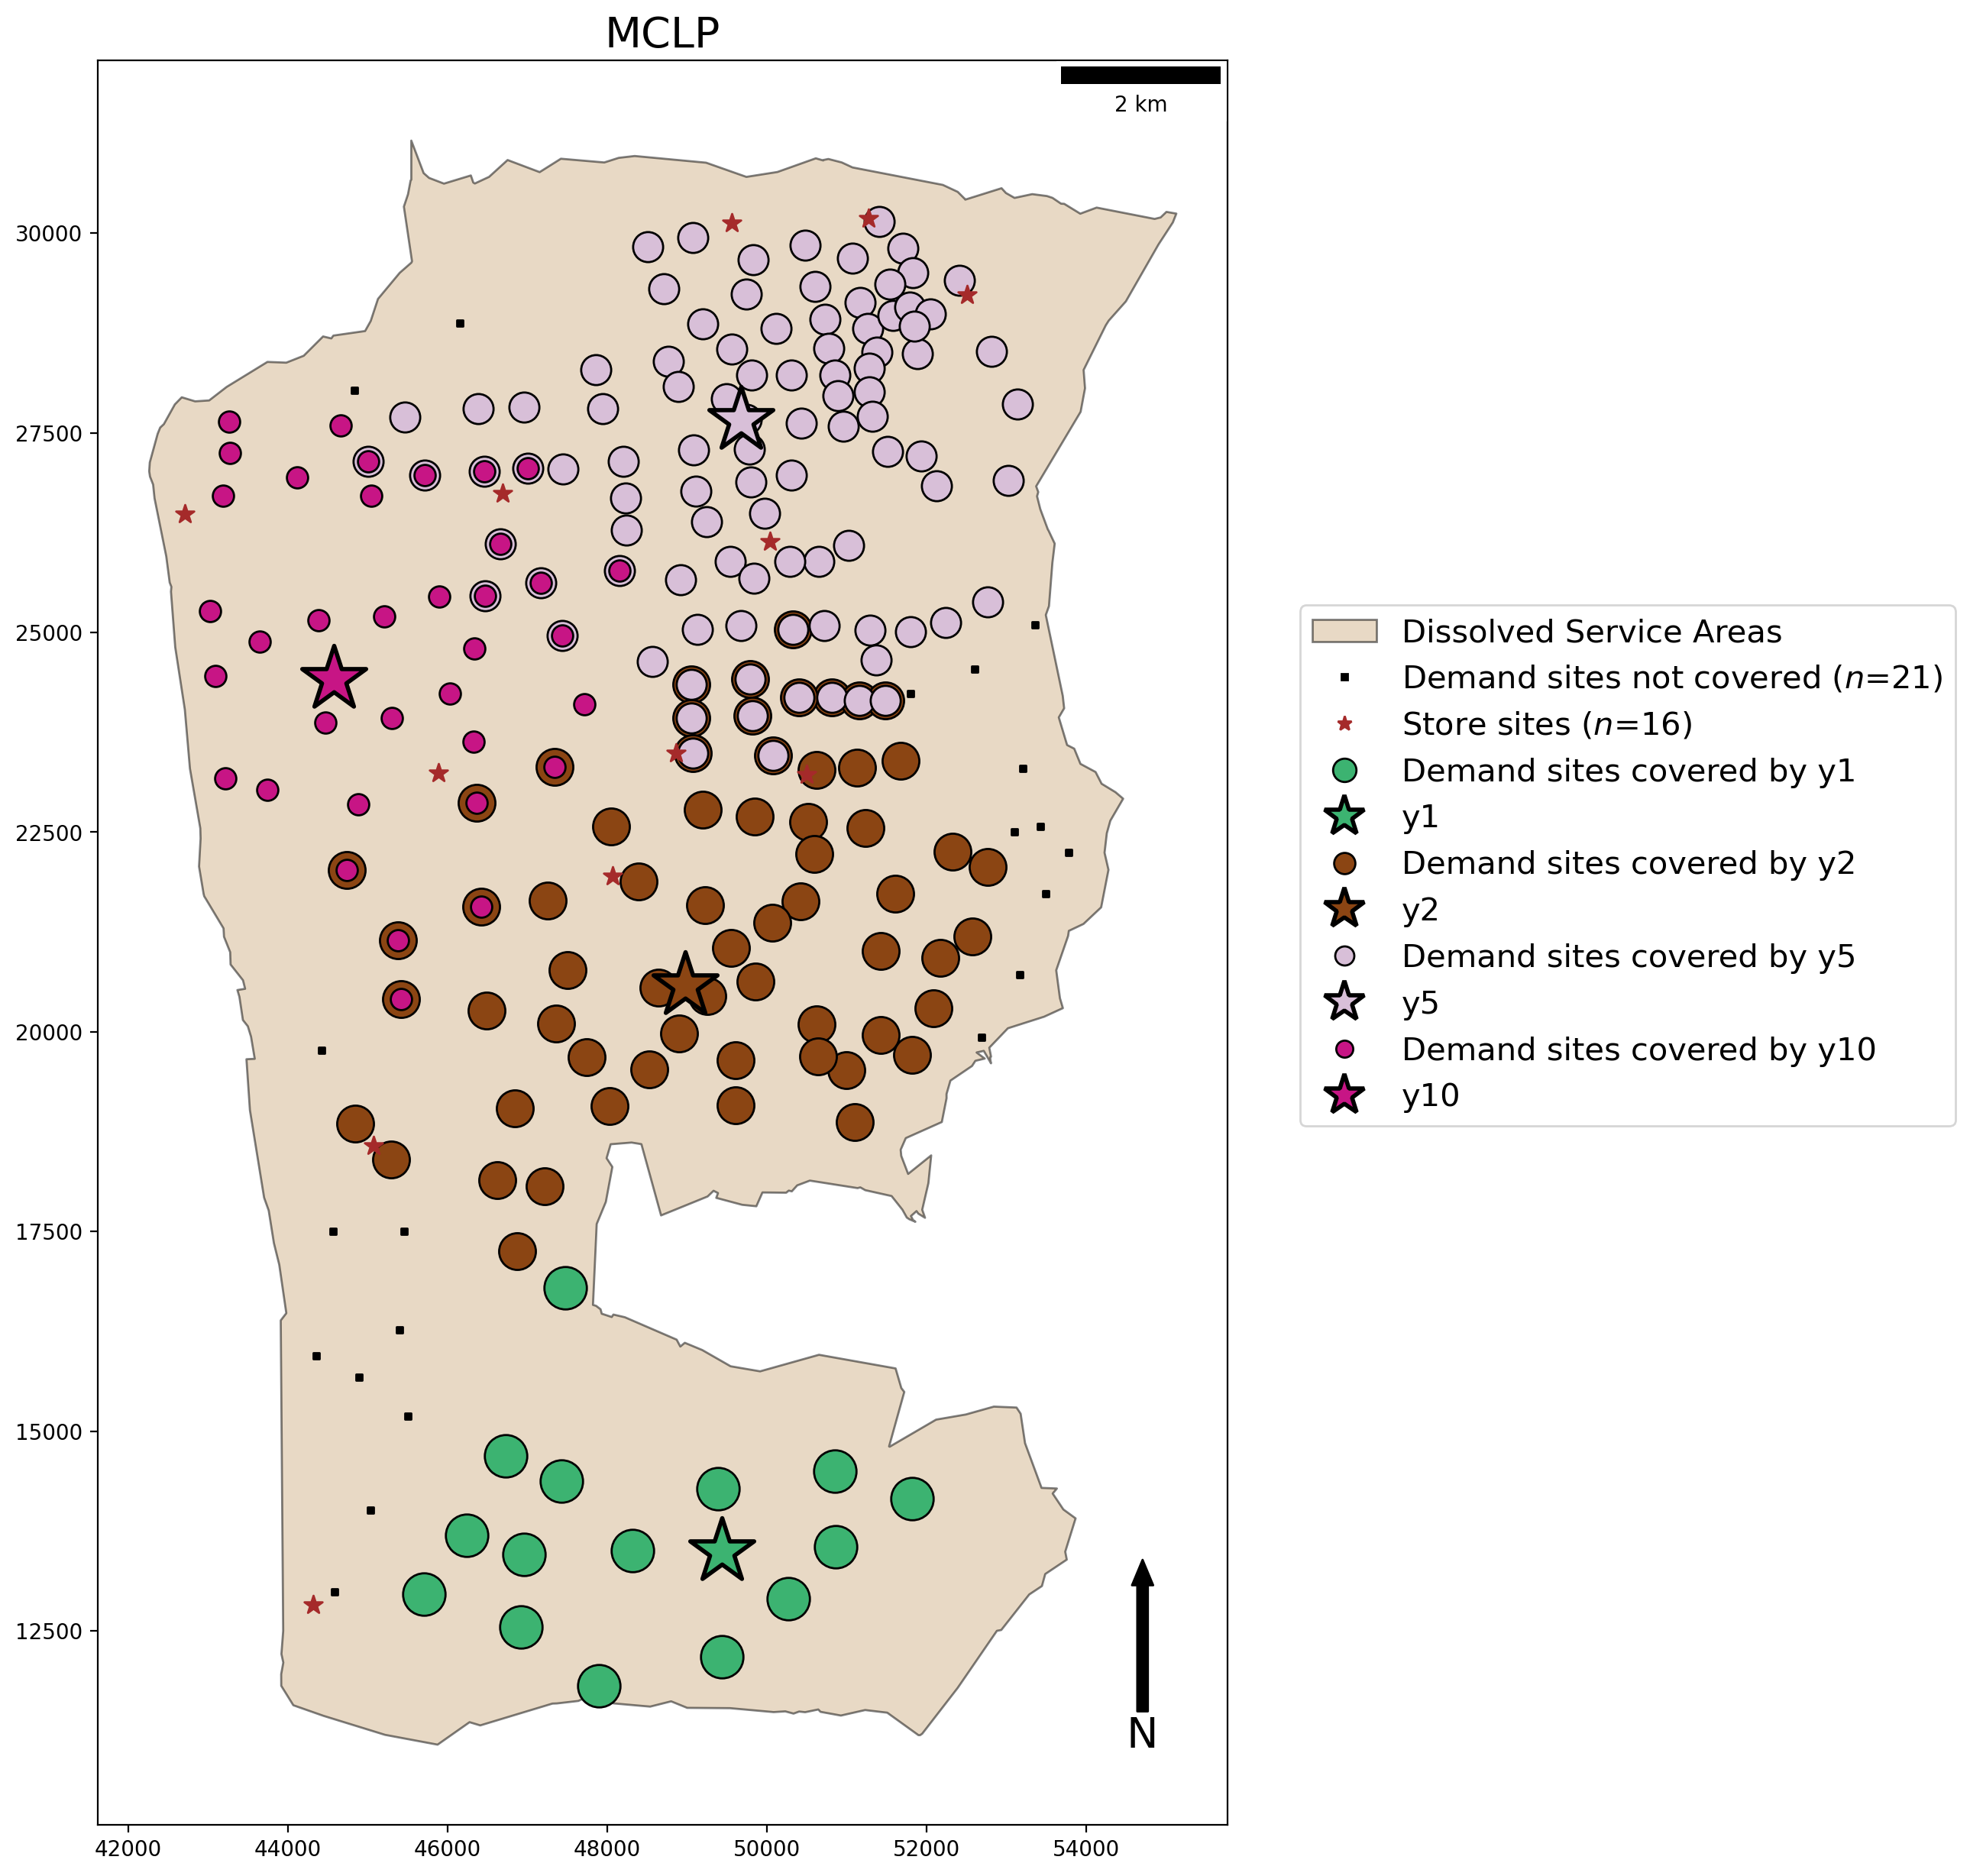

In [26]:
plot_results(
    mclp,
    facility_points_gdf,
    demand_points_gdf,
    n_fac_pnts,
    "MCLP",
    4,
)

In [27]:
mclp.problem.objective.value()

875247

### MCLP Percentage Covered

In [28]:
mclp.uncovered_clients()
mclp.get_percentage()
mclp.percentage

0.8975609756097561

## P-Center

In [29]:
from spopt.locate import PCenter

In [30]:
pcenter = PCenter.from_cost_matrix(cost_matrix, p_facilities=p_facility)

In [31]:
pcenter = pcenter.solve(pulp.GLPK(msg=False))

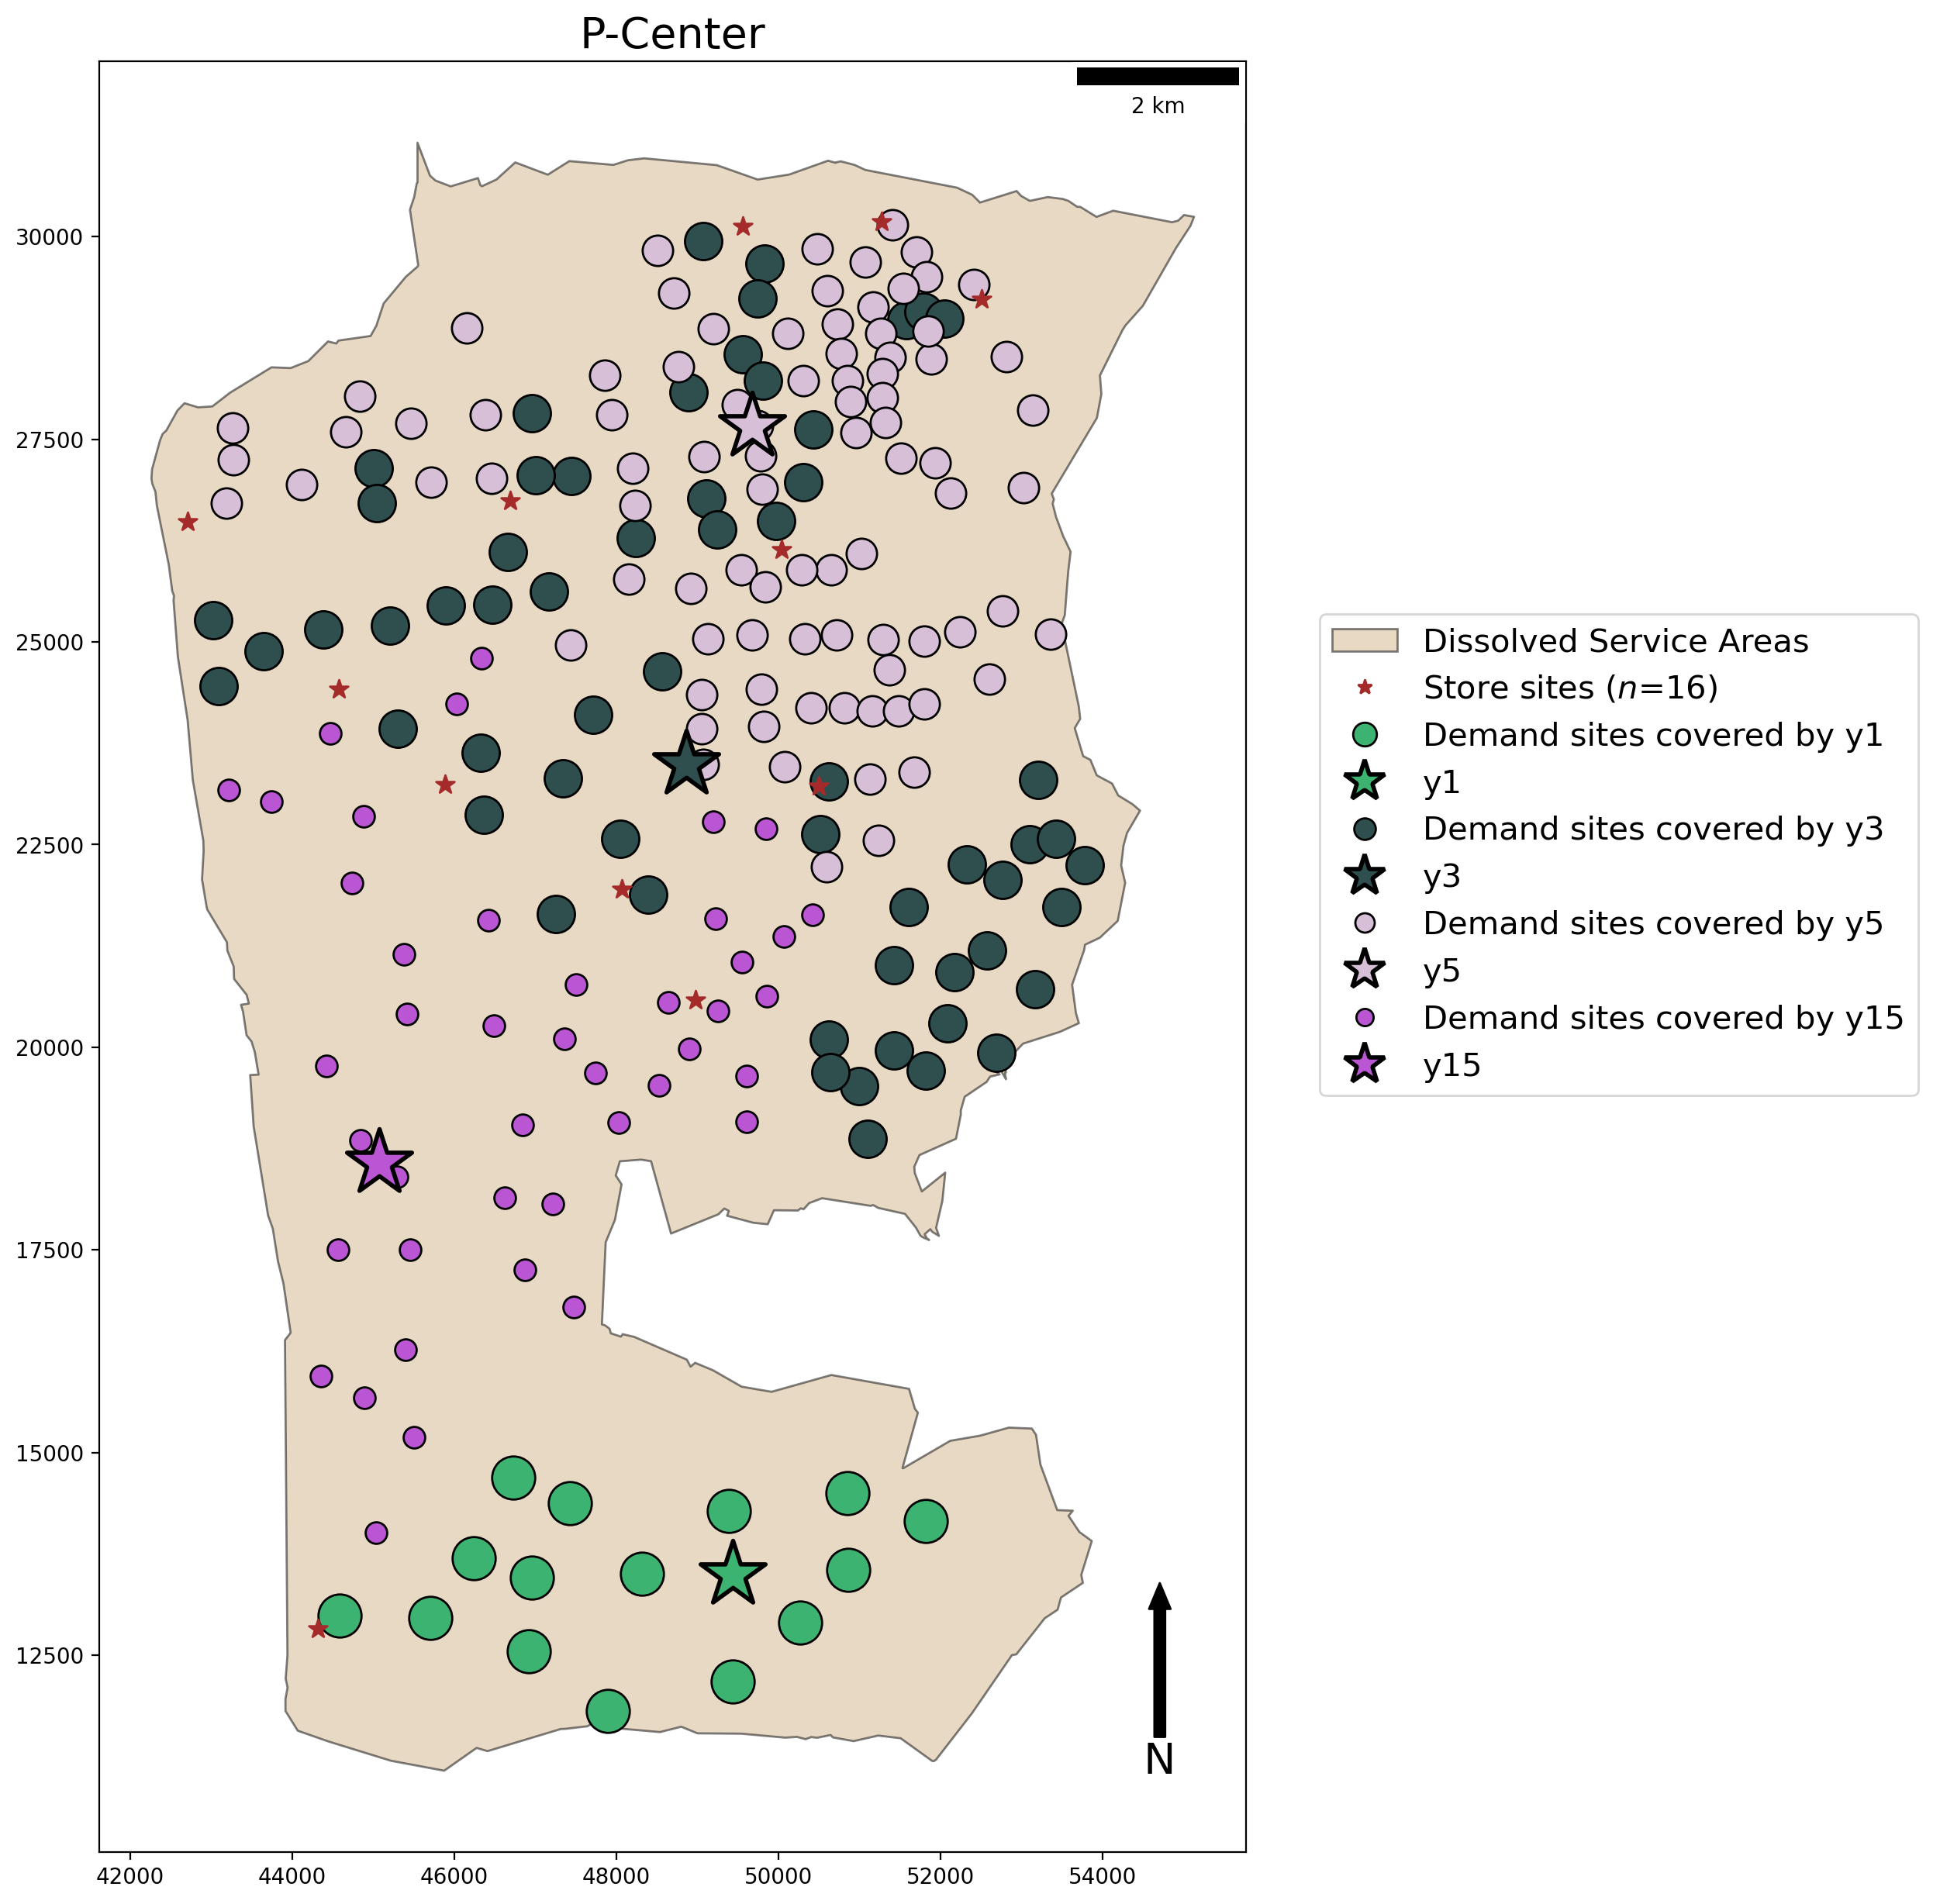

In [32]:
plot_results(
    pcenter,
    facility_points_gdf,
    demand_points_gdf,
    n_fac_pnts,
    "P-Center",
    p_facility,
)

In [33]:
pcenter.problem.objective.value()

7403.06

## P-Median

In [34]:
from spopt.locate import PMedian

In [35]:
pmedian = PMedian.from_cost_matrix(cost_matrix, ai, p_facilities=p_facility)

In [36]:
pmedian = pmedian.solve(pulp.GLPK(msg=False))

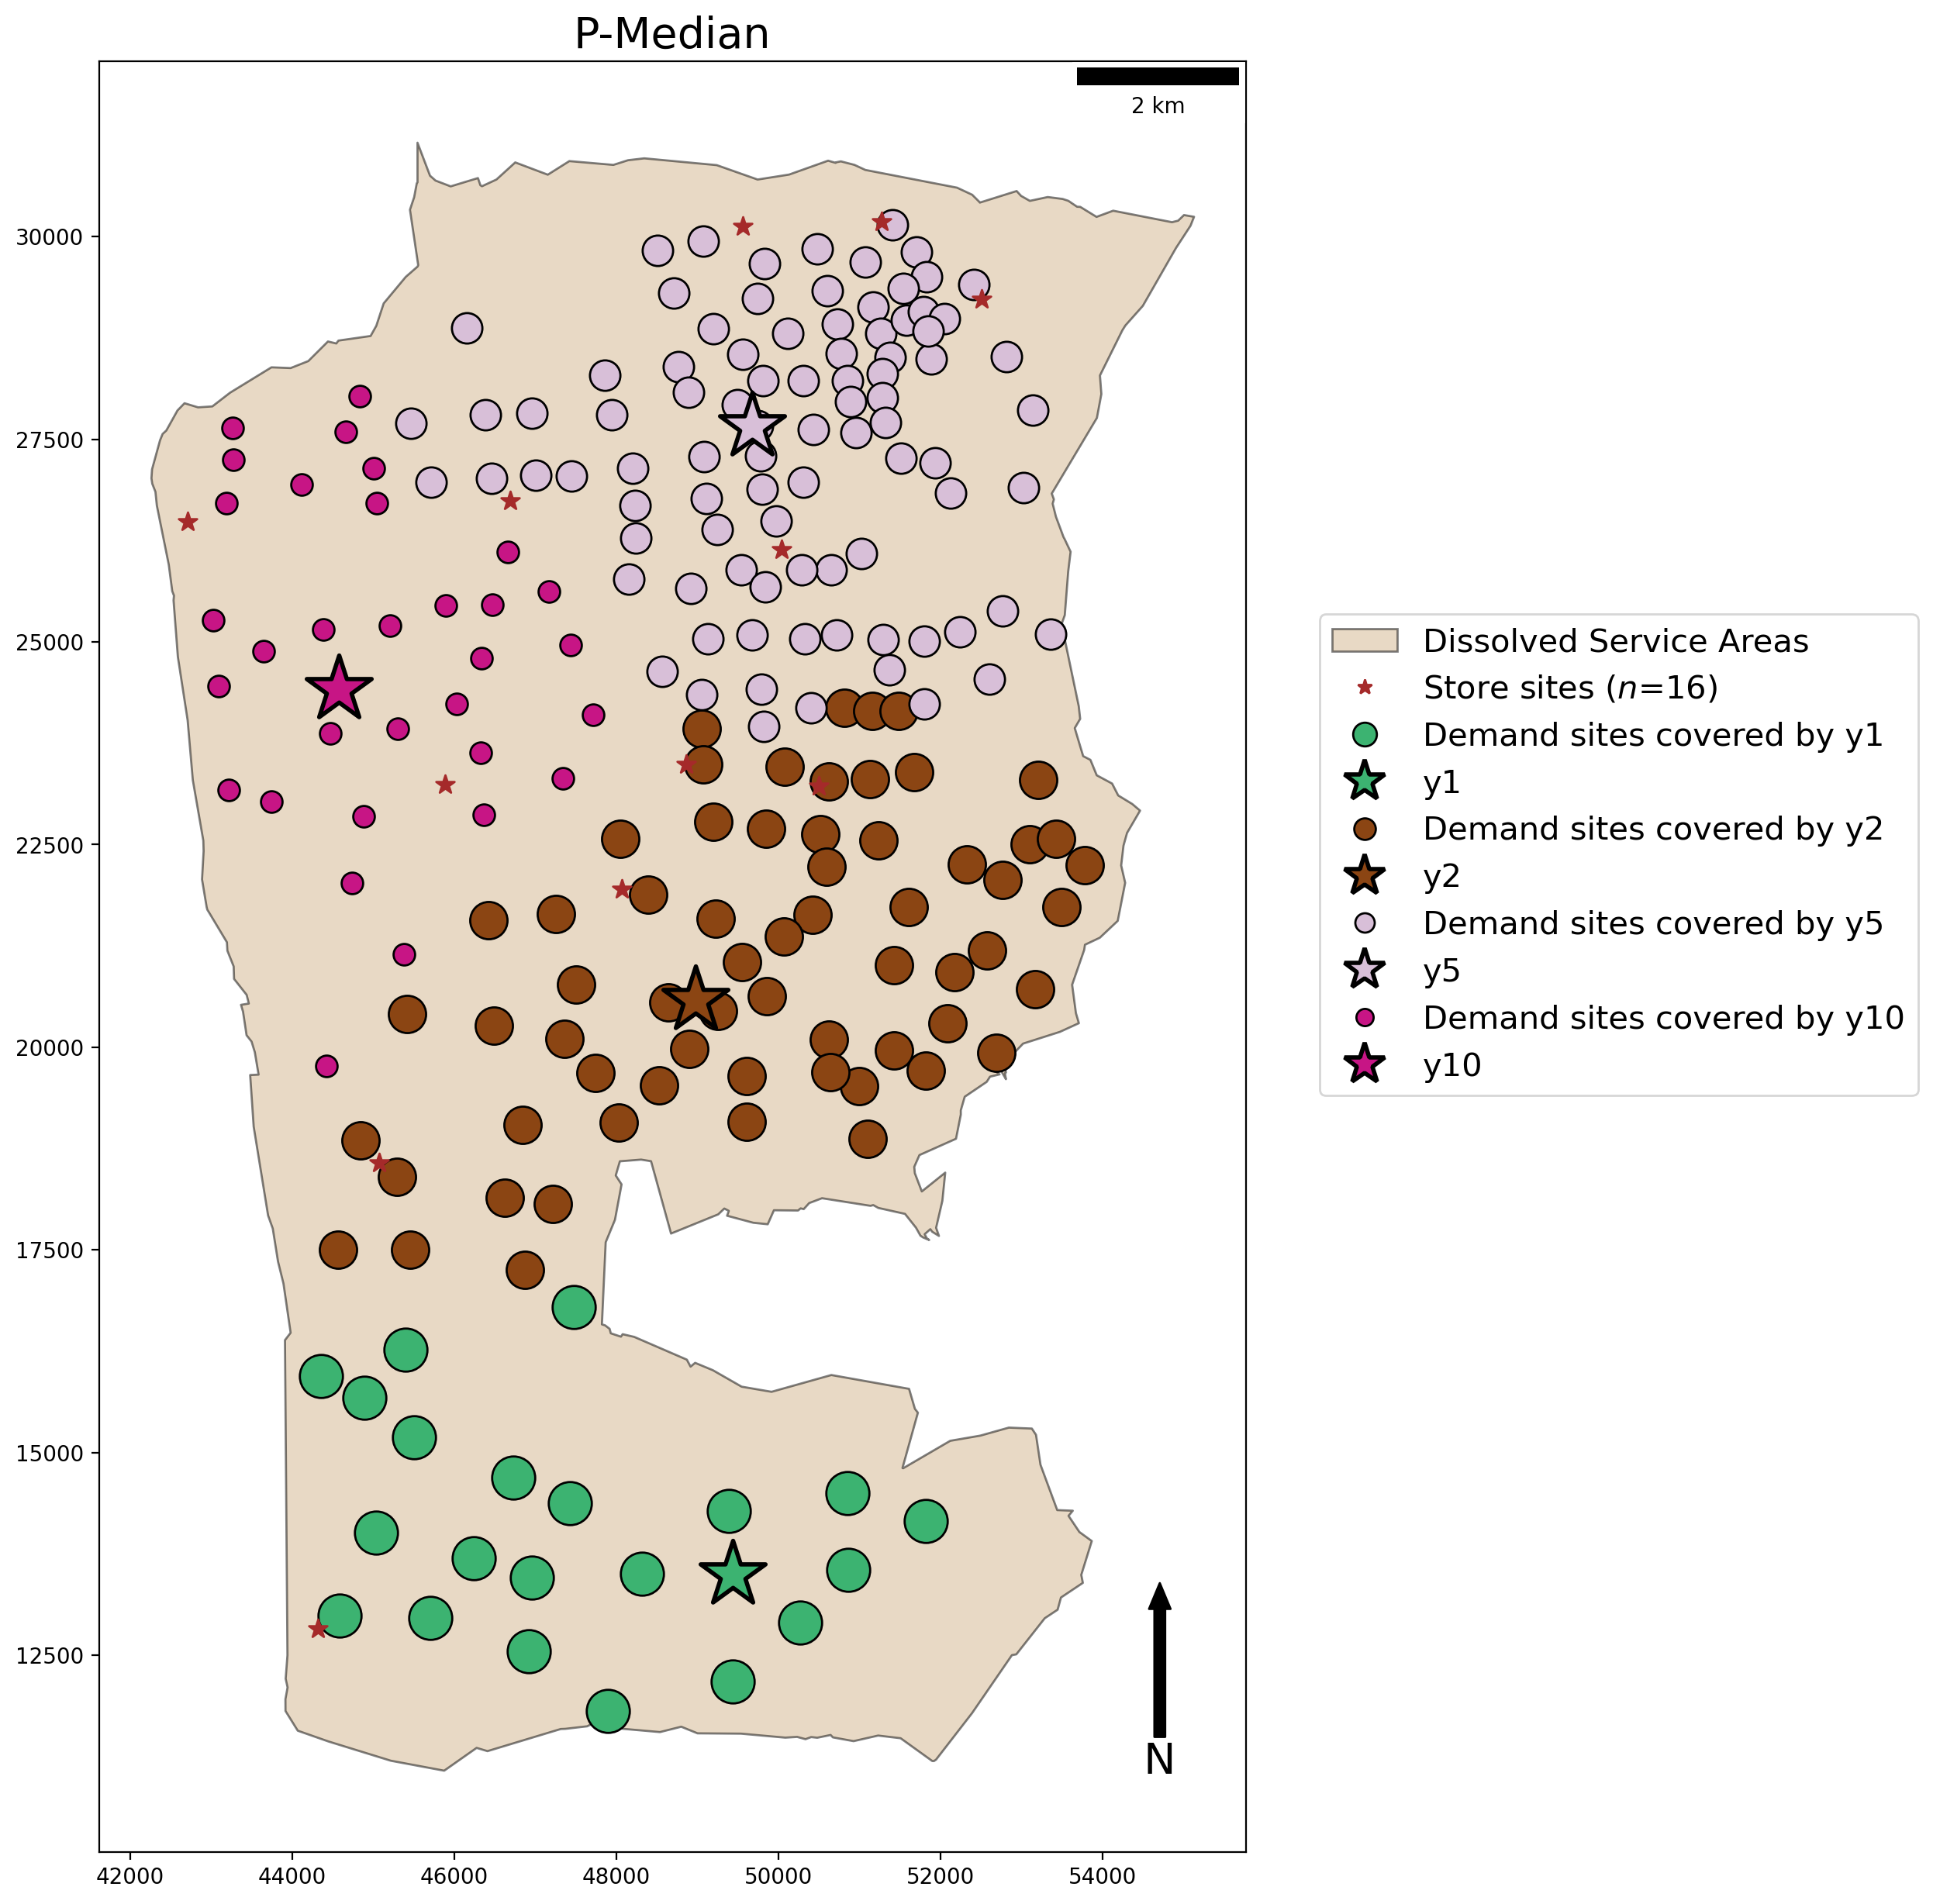

In [37]:
plot_results(
    pmedian,
    facility_points_gdf,
    demand_points_gdf,
    n_fac_pnts,
    "P-Median",
    p_facility,
)

In [38]:
pmedian.problem.objective.value()

2848268129.7145104

In [39]:
pmedian.get_mean_distance(weight=ai)
pmedian.mean_dist

2982.1268579890657

## Using different solver for one model

For this task we get the MCLP model as example.

In [40]:
mclp = MCLP.from_cost_matrix(
    cost_matrix,
    ai,
    service_radius=service_dist,
    p_facilities=4,
)

First, it's good to see which solver you have installed in your machine.

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    solvers = pulp.listSolvers(onlyAvailable=True)
solvers

['GLPK_CMD', 'CPLEX_CMD', 'PULP_CBC_CMD', 'COIN_CMD', 'SCIP_CMD']

Above we can see that it returns a list with different solvers that are available. So, it's up to user choose the best solver that fits the model. Let's get the percentage as a metric to evaluate which solver is the best or improves the model.

In [42]:
results = pandas.DataFrame(columns=["Coverage %", "Solve Time (sec.)"], index=solvers)
for solver in solvers:
    mclp = mclp.solve(pulp.get_solver(solver, msg=False))
    mclp.get_percentage()
    results.loc[solver] = [mclp.percentage, mclp.problem.solutionTime]
results

,Coverage %,Solve Time (sec.)
GLPK_CMD,0.897561,0.026377
CPLEX_CMD,0.897561,0.452633
PULP_CBC_CMD,0.897561,0.024634
COIN_CMD,0.897561,0.055517
SCIP_CMD,0.897561,0.233934


-----------------------